# Phase 3 - Machine Learning
### Authors: Karolina Skrypova(50%), Oleh Fedunchyk(50%)

## Importing libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, ClassifierMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold

## Loading the data

In [29]:
connections_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/connections.csv', sep='\t')
processes_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/processes.csv', sep='\t')

## Datasets for processing

Our constants:

In [30]:
selected_attributes = [
    "mwra",
    "p.android.externalstorage",
    "p.android.settings",
    "p.android.gm",
    "p.system",
    "p.android.packageinstaller",
    "c.android.gm",
    "c.android.youtube",
    "p.android.chrome",
    "c.android.chrome"
]

In [31]:
merged_data = pd.merge(processes_data, connections_data).drop_duplicates()
train_data, test_data = train_test_split(merged_data[selected_attributes], test_size=0.2, random_state=42)
mwra_train = pd.DataFrame(train_data.pop('mwra'))
mwra_test = pd.DataFrame(test_data.pop('mwra'))

Let's take a look at the data and whether their distributions are similar:

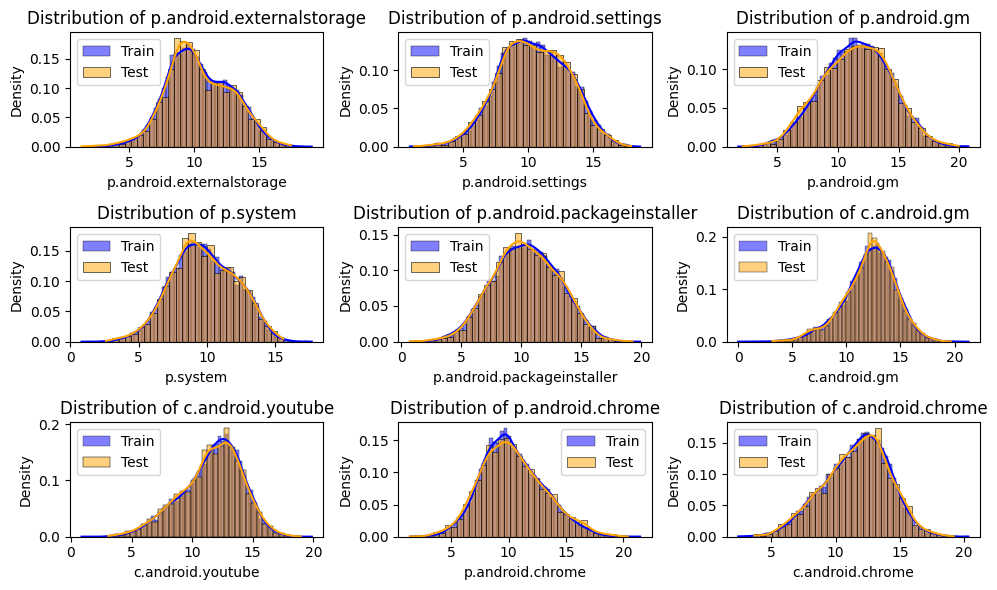

In [32]:
num_columns = 3
num_rows = 3
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, num_rows * 2))
axes = axes.flatten()

for idx, column in enumerate(train_data.columns):
    sns.histplot(train_data[column], color='blue', label='Train', kde=True, stat="density", ax=axes[idx])
    sns.histplot(test_data[column], color='orange', label='Test', kde=True, stat="density", ax=axes[idx])
    axes[idx].set_title(f'Distribution of {column}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

As we can see, the distributions of the data are similar, so we can proceed with the data pre-processing.

## Data pre-processing pipeline

And now let's modify the pipeline and it's elements from phase 2 to be able to create more general version of it:

### Data cleaning

In [33]:
class Cleaner(TransformerMixin):
    def __init__(self, outlier_strategy):
        self.outlier_strategy = outlier_strategy

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self.transform_outliers)

    def transform_outliers(self, df_column):
        Q1 = df_column.quantile(0.25)
        Q3 = df_column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        if self.outlier_strategy == 'mean':
            mean_value = df_column.mean()
            return df_column.where((df_column >= lower_bound) & (df_column <= upper_bound), mean_value)
        elif self.outlier_strategy == 'median':
            median_value = df_column.median()
            return df_column.where((df_column >= lower_bound) & (df_column <= upper_bound), median_value)
        elif self.outlier_strategy == 'clip':
            return df_column.clip(lower=lower_bound, upper=upper_bound)
        else:
            ValueError('Invalid outlier strategy')

### Data transforming

In [34]:
class Transformer(TransformerMixin):
    def __init__(self, transformer):
        self.transformer = transformer

    def fit(self, X, y=None):
        self.transformer.fit(X)
        return self

    def transform(self, X):
        return pd.DataFrame(self.transformer.transform(X), columns=X.columns)

### Data scaling

In [35]:
class Scaler(TransformerMixin):
    def __init__(self, scaler):
        self.scaler = scaler

    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self

    def transform(self, X):
        return pd.DataFrame(self.scaler.transform(X), columns=X.columns)

### Pipeline

In [36]:
pipeline = Pipeline([
    ('cleaner', Cleaner('clip')),
    ('transformer', Transformer(PowerTransformer(method='yeo-johnson', standardize=True))),
    ('scaler', Scaler(MinMaxScaler()))
]).fit(train_data, mwra_train)

In [37]:
train_data_transformed = pipeline.transform(train_data)
test_data_transformed = pipeline.transform(test_data)

## Simple ID3 classifier based on dependencies in the data

### ID3 classifier algorithm

Before we go on to the implementation of the algorithm, you can see its pseudocode below (slide from the **lecture**). The slide also mentions that this algorithm works for **categorical** values, but our dataset consists of numerical values, so in the implementation we used the idea that we will divide each attribute into intervals, which will just be a kind of category.

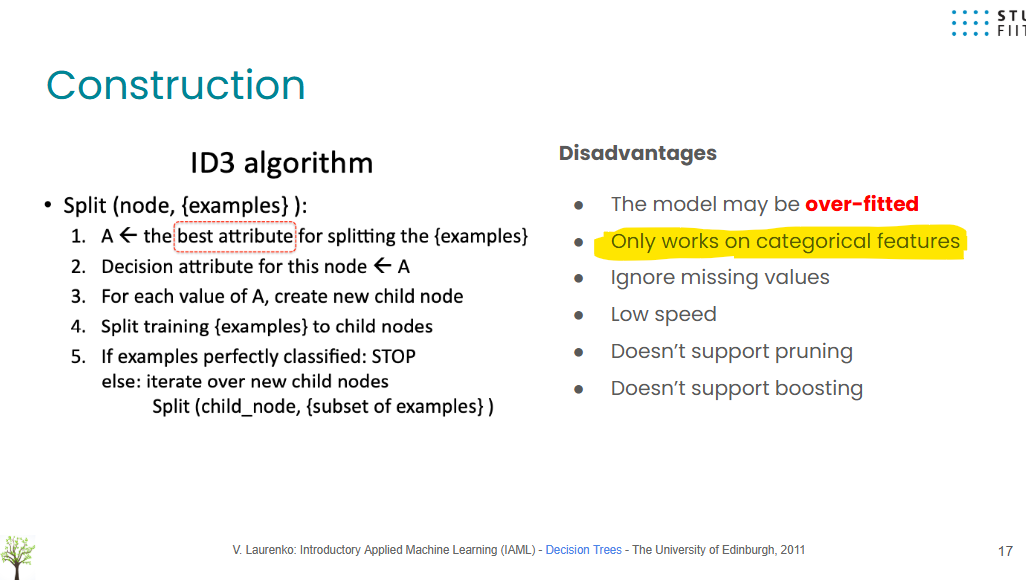

In [38]:
class ClassifierID3(ClassifierMixin):

    class TreeNode:
        def __init__(self, dataset, depth, attribute=None, interval_lower_bound=None, interval_upper_bound=None):
            self.dataset = dataset
            self.depth = depth
            self.attribute = attribute
            self.interval_lower_bound = interval_lower_bound
            self.interval_upper_bound = interval_upper_bound
            self.children = []
            self.predicted_value = None  # only for leaf nodes

        def is_leaf(self):
            return self.predicted_value is not None


    def __init__(self, intervals_number=None, max_depth=None):
        if max_depth is not None and max_depth <= 2:
            raise ValueError("Min depth must be at least 2.")

        if  intervals_number is None or intervals_number < 2:
            raise ValueError("Intervals number must be at least 2.")

        self.max_depth = max_depth
        self.intervals_number = intervals_number
        self.target_attribute = None
        self.tree = None

    def fit(self, X, y):
        # Combine the features (X) and target (y) into one DataFrame
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)

        X['index'] = X.index
        y['index'] = y.index

        data = pd.merge(X, y, on='index')
        data = data.drop(columns=['index'])

        self.target_attribute = y.columns[0]

        # Building the tree
        root = self.TreeNode(data, 0)
        self.tree = self._build_tree(root)

        return self


    def _build_tree(self, node):

        # Calculate the frequency of ea(ch class label (target attribute)
        target_counts = node.dataset[self.target_attribute].value_counts()


        # If all labels are the same, return a leaf node
        if len(target_counts) == 1:
            node.predicted_value = target_counts.index[0]
            return node

        # If max depth is reached or dataset has 1 attribute, create a leaf node with the most frequent class
        if node.depth == self.max_depth or len(node.dataset.columns) == 1:
            node.predicted_value = target_counts.idxmax()
            return node

        # Find the best attribute to split on
        best_attribute = self._get_best_attribute_for_split(node.dataset)
        node.attribute = best_attribute
        # print(best_attribute)

        # Split the data based on the chosen attribute into intervals
        intervals = self._get_intervals(node.dataset[best_attribute])

        # creating children
        interval_lower_bound = intervals[0]
        for interval_upper_bound in intervals[1:]:
            # Create a child node for the current interval
            child_data = self._get_dataset_in_interval(node.dataset, best_attribute, interval_lower_bound, interval_upper_bound).drop(best_attribute, axis=1)

            if not child_data.empty:
                child_node = self.TreeNode(dataset=child_data, depth=node.depth + 1, interval_lower_bound=interval_lower_bound, interval_upper_bound=interval_upper_bound)
                node.children.append(child_node)

            interval_lower_bound = interval_upper_bound

        # recursion
        for child in node.children:
            self._build_tree(child)

        return node


    def _get_best_attribute_for_split(self, dataset):
        """
        Calculate the Information Gain for all attributes and return the best one.
        """
        best_info_gain = -np.inf
        best_attribute = None

        for attribute in dataset.columns:
            if attribute != self.target_attribute:
                info_gain = self._information_gain(dataset, attribute)
                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_attribute = attribute

        return best_attribute

    def _information_gain(self, dataset, attribute):
        """
        Calculate the information gain.
        """
        entropy_before = self._entropy(dataset)

        splits = self._split_data_by_attribute(dataset, attribute)
        total_count = len(dataset)

        weighted_entropy = 0.0
        for split in splits:
            weighted_entropy += (len(split) / total_count) * self._entropy(split)

        return entropy_before - weighted_entropy

    def _entropy(self, dataset):
        """
        Calculate the entropy of the target attribute.
        """
        class_counts = dataset[self.target_attribute].value_counts()
        total_count = len(dataset)
        entropy = 0.0

        for count in class_counts:
            probability = count / total_count
            entropy -= probability * np.log2(probability)

        return entropy


    def _split_data_by_attribute(self, dataset, attribute):
        """
        Split the dataset by the attribute value intervals.
        """
        splits = []

        # Split the data based on the chosen attribute into intervals
        intervals = self._get_intervals(dataset[attribute])

        interval_lower_bound = intervals[0]
        for interval_upper_bound in intervals[1:]:
            splits.append(self._get_dataset_in_interval(dataset, attribute, interval_lower_bound, interval_upper_bound))
            interval_lower_bound = interval_upper_bound

        return splits

    def _get_intervals(self, attribute_values):
        """
        Create intervals based on the attribute values.
        """
        min_value, max_value = attribute_values.min(), attribute_values.max()
        interval_size = (max_value - min_value) / self.intervals_number

        intervals = [min_value + i * interval_size for i in range(self.intervals_number + 1)]
        return intervals

    def _get_dataset_in_interval(self, dataset, attribute, lower_bound, upper_bound):
        """
        Return the subset of the dataset where the attribute values fall within the given interval.
        """
        return dataset[(dataset[attribute] >= lower_bound) & (dataset[attribute] < upper_bound)]




    def predict(self, X):
        """
        Predict the class for a new sample using the trained tree.
        """
        predictions = []
        for index, row in X.iterrows():
            prediction = self._predict_sample(row)
            predictions.append(prediction)

        return predictions

    def _predict_sample(self, sample):
        """
        Predict the class label for a single sample.
        """
        node = self.tree

        while not node.is_leaf():
            value = sample[node.attribute]

            smallest_interval_node = node.children[0]
            biggest_interval_node = node.children[0]

            for child in node.children:

                # Check if the value falls within the interval of the child node
                if child.interval_lower_bound <= value < child.interval_upper_bound:
                    node = child
                    break

                if child.interval_lower_bound < smallest_interval_node.interval_lower_bound:
                    smallest_interval_node = child
                if child.interval_upper_bound > biggest_interval_node.interval_upper_bound:
                    biggest_interval_node = child

            # If no matching interval found, assign to the closest bound
            else:
                if value < smallest_interval_node.interval_lower_bound:
                    # Assign to lowest interval
                    node = smallest_interval_node
                else:
                    # Assign to highest interval
                    node = biggest_interval_node


        # print(node.predicted_value)
        return node.predicted_value

### Classifier evaluation

In [39]:
classifier = ClassifierID3(intervals_number=3, max_depth=5)
classifier.fit(train_data_transformed, mwra_train)

#Make predictions using the transformed data
test_pred = classifier.predict(test_data_transformed)
train_pred = classifier.predict(train_data_transformed)

train_accuracy = accuracy_score(mwra_train, train_pred)
accuracy = accuracy_score(mwra_test, test_pred)

train_precision = precision_score(mwra_train, train_pred)
train_recall = recall_score(mwra_train, train_pred)
test_precision = precision_score(mwra_test, test_pred)
test_recall = recall_score(mwra_test, test_pred)

print(f"ID3: Train Accuracy: {train_accuracy}")
print(f"ID3: Test Accuracy: {accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Test Precision: {test_precision}")
print(f"Train Recall: {train_recall}")
print(f"Test Recall: {test_recall}")

ID3: Train Accuracy: 0.8895756765786836
ID3: Test Accuracy: 0.885733377881724
Train Precision: 0.8954802259887006
Test Precision: 0.8911042944785276
Train Recall: 0.9321037155840685
Test Recall: 0.9310897435897436


These values indicate that the model is accurate and reliable on both training and test datasets, with high precision and recall. The model detects about 93.1% of true positive examples on the training data. Also, the model seems to be not overfitting, as the training and test scores are close.

### Overfitting

To determine if the model is overfitting, we can compare the training and test scores. If the training score is significantly higher than the test score, the model is likely overfitting. If the training and test scores are close, the model is not overfitting. So let's see how model performs on different input parameters (max_depth and intervals_number):

Iteration 1:
Parameters: {'intervals_number': 2, 'max_depth': 3}
Train Accuracy: 0.8460574674239894
Test Accuracy: 0.838623454727698
Iteration 2:
Parameters: {'intervals_number': 2, 'max_depth': 4}
Train Accuracy: 0.8725359171399933
Test Accuracy: 0.8573337788172403
Iteration 3:
Parameters: {'intervals_number': 2, 'max_depth': 5}
Train Accuracy: 0.8839792849983295
Test Accuracy: 0.8686936184430337
Iteration 4:
Parameters: {'intervals_number': 2, 'max_depth': 6}
Train Accuracy: 0.8864851319746074
Test Accuracy: 0.8723688606749082
Iteration 5:
Parameters: {'intervals_number': 3, 'max_depth': 3}
Train Accuracy: 0.860090210491146
Test Accuracy: 0.8596725693284331
Iteration 6:
Parameters: {'intervals_number': 3, 'max_depth': 4}
Train Accuracy: 0.8728700300701637
Test Accuracy: 0.8700300701637154
Iteration 7:
Parameters: {'intervals_number': 3, 'max_depth': 5}
Train Accuracy: 0.8895756765786836
Test Accuracy: 0.885733377881724
Iteration 8:
Parameters: {'intervals_number': 3, 'max_depth': 6}


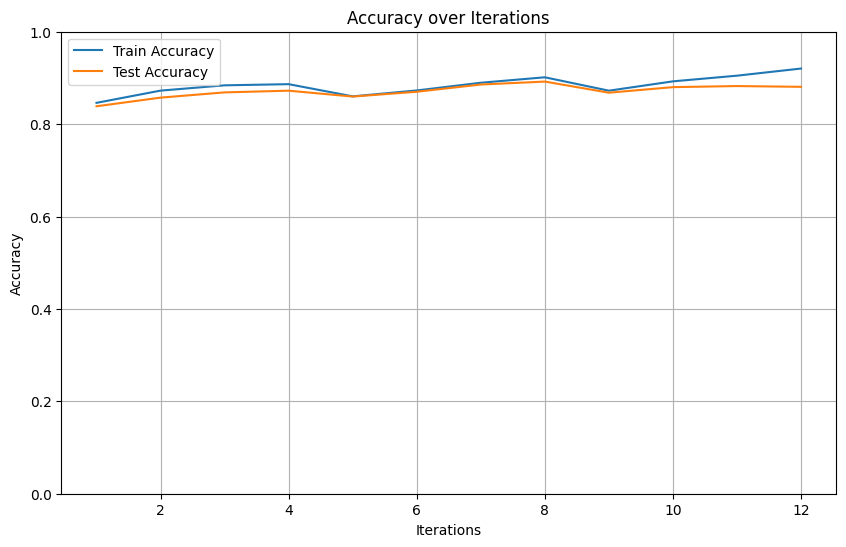

In [40]:
def train_and_evaluate_model_with_params(ClassifierID3, param_dict, train_data_transformed, mwra_train, test_data_transformed, mwra_test):
    best_model = None
    best_accuracy = 0
    best_params = None
    train_accuracies = []
    test_accuracies = []

    keys, values = zip(*param_dict.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    for i, params in enumerate(param_combinations):
        classifier = ClassifierID3(**params)
        classifier.fit(train_data_transformed, mwra_train)
        train_pred = classifier.predict(train_data_transformed)
        test_pred = classifier.predict(test_data_transformed)
        train_accuracy = accuracy_score(mwra_train, train_pred)
        test_accuracy = accuracy_score(mwra_test, test_pred)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Iteration {i+1}:")
        print(f"Parameters: {params}")
        print(f"Train Accuracy: {train_accuracy}")
        print(f"Test Accuracy: {test_accuracy}")

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = classifier
            best_params = params

    print(f"Best Parameters: {best_params}")
    print(f"Best Accuracy: {best_accuracy}")

    # graf for accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.title('Accuracy over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_model, best_accuracy

# iteration parameters
param_dict = {
    'intervals_number': [2, 3, 4],
    'max_depth': [3, 4, 5, 6]
}

best_model, best_accuracy = train_and_evaluate_model_with_params(ClassifierID3, param_dict, train_data_transformed, mwra_train, test_data_transformed, mwra_test)


The model is not overfitting, as the training and test scores are close. The best accuracy is 0.892, which is a good result. But, also as we can see if we increase the max_depth and intervals_number the classifier predictions on the test and train data will be more different, it is because then the model will not learn the data but memorize it. So to have the data generalized we need to have a balance between the max_depth and intervals_number. And the best pair of parameters is intervals_number=3 and max_depth=6.

## Training and evaluation of machine learning classifiers

### Decision Tree Classifier

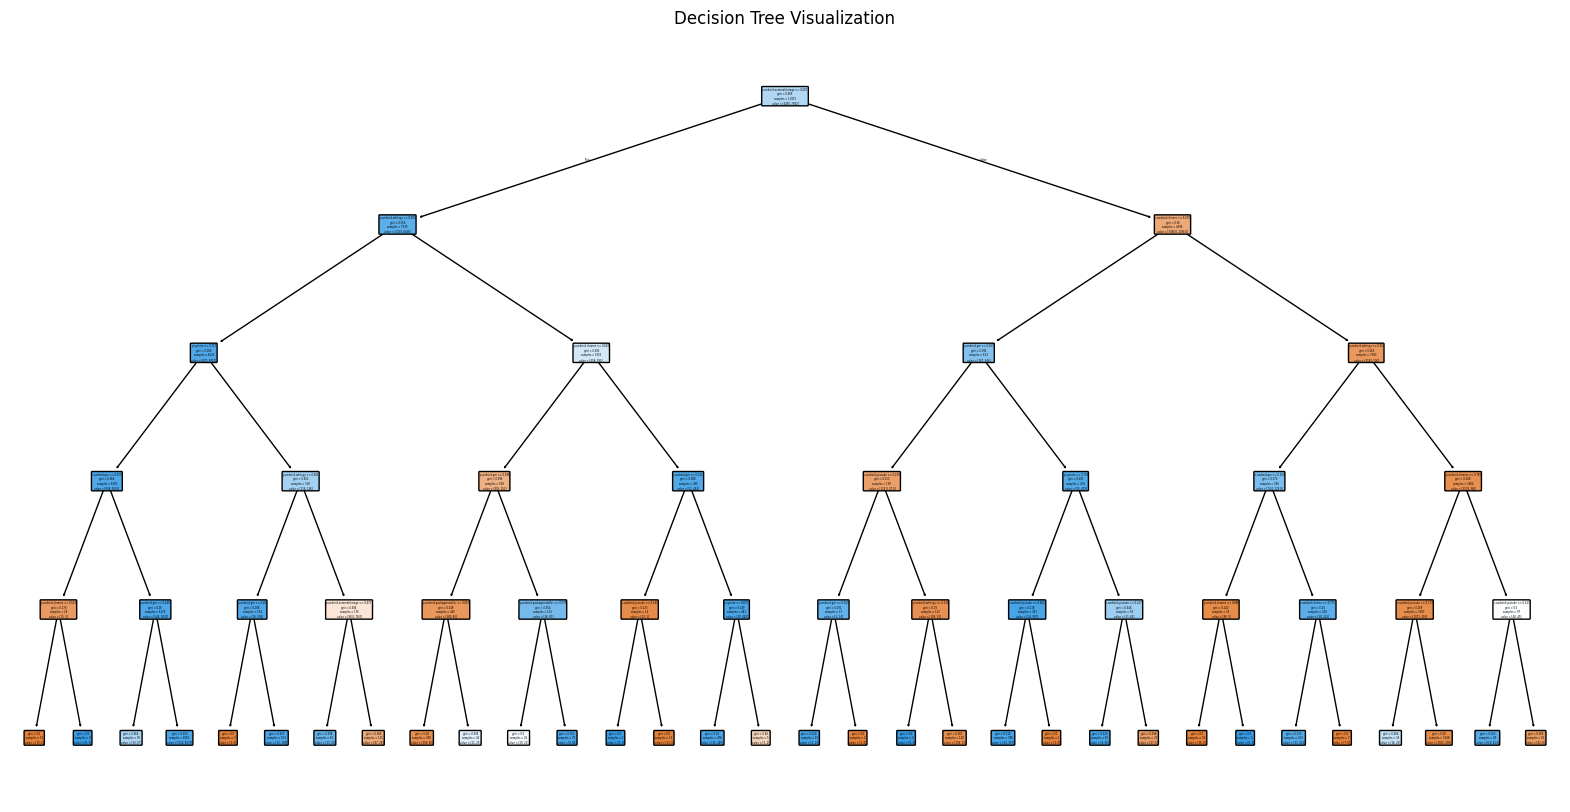

Decision Tree - Train Accuracy: 0.9065319077848313
Decision Tree - Test Accuracy: 0.8964249916471767
Train Precision: 0.9065814696485623
Train Recall: 0.9481422079657845
Test Precision: 0.896849593495935
Test Recall: 0.9428418803418803


In [41]:
mwra_train = mwra_train.values.ravel()
mwra_test = mwra_test.values.ravel()

tree_classifier = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_classifier.fit(train_data_transformed, mwra_train)

plt.figure(figsize=(20, 10))
plot_tree(
    tree_classifier,
    feature_names=train_data.columns,
    filled=True,
    rounded=True
)
plt.title("Decision Tree Visualization")
plt.show()

#Make predictions using the transformed data
tree_train_pred = tree_classifier.predict(train_data_transformed)
tree_test_pred = tree_classifier.predict(test_data_transformed)

tree_train_accuracy = accuracy_score(mwra_train, tree_train_pred)
tree_test_accuracy = accuracy_score(mwra_test, tree_test_pred)

train_precision = precision_score(mwra_train, tree_train_pred)
train_recall = recall_score(mwra_train, tree_train_pred)
test_precision = precision_score(mwra_test, tree_test_pred)
test_recall = recall_score(mwra_test, tree_test_pred)

print(f"Decision Tree - Train Accuracy: {tree_train_accuracy}")
print(f"Decision Tree - Test Accuracy: {tree_test_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")


Results decription: The accuracy was pretty simmilar to ID3, but it was faster and better results in test accuracy.

### SVC - Support Vector Classifier

In [42]:
logistic_classifier = SVC(kernel='linear', random_state=42)
logistic_classifier.fit(train_data_transformed, mwra_train)

logistic_train_pred = logistic_classifier.predict(train_data_transformed)
logistic_test_pred = logistic_classifier.predict(test_data_transformed)

logistic_train_accuracy = accuracy_score(mwra_train, logistic_train_pred)
logistic_test_accuracy = accuracy_score(mwra_test, logistic_test_pred)

train_precision = precision_score(mwra_train, logistic_train_pred)
train_recall = recall_score(mwra_train, logistic_train_pred)
test_precision = precision_score(mwra_test, logistic_test_pred)
test_recall = recall_score(mwra_test, logistic_test_pred)

print(f"SVC - Train Accuracy: {logistic_train_accuracy}")
print(f"SVC - Test Accuracy: {logistic_test_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

SVC - Train Accuracy: 0.9149682592716338
SVC - Test Accuracy: 0.9097895088539927
Train Precision: 0.9213820078226858
Train Recall: 0.9445335471798985
Test Precision: 0.9116135662898253
Test Recall: 0.9476495726495726


Support Vector Classifier shows a good performance in this dataset. The model has a stable and balanced performance, with closely matching training and test scores. But it has lower recall compared to others.

### Random forest classifier

In [43]:
tree_classifier = RandomForestClassifier(n_estimators=100, max_depth=5)
tree_classifier.fit(train_data_transformed, mwra_train)

#Make predictions using the transformed data
tree_train_pred = tree_classifier.predict(train_data_transformed)
tree_test_pred = tree_classifier.predict(test_data_transformed)

tree_train_accuracy = accuracy_score(mwra_train, tree_train_pred)
tree_test_accuracy = accuracy_score(mwra_test, tree_test_pred)
train_precision = precision_score(mwra_train, tree_train_pred)
train_recall = recall_score(mwra_train, tree_train_pred)
test_precision = precision_score(mwra_test, tree_test_pred)
test_recall = recall_score(mwra_test, tree_test_pred)

print(f"RandomForestClassifier - Train Accuracy: {tree_train_accuracy}")
print(f"RandomForestClassifier - Test Accuracy: {tree_test_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

RandomForestClassifier - Train Accuracy: 0.9196458402940194
RandomForestClassifier - Test Accuracy: 0.9111259605746742
Train Precision: 0.9177344951307022
Train Recall: 0.9572306869820904
Test Precision: 0.9072008113590264
Test Recall: 0.9556623931623932


We can see that the Random Forest Classifier has the good performance, with an accuracy of 0.91. High test accuracy and recall indicate the model generalizes well, especially for identifying positive cases. Also there is no overfitting.

### KNeighborsClassifier

In [44]:
logistic_classifier = KNeighborsClassifier(n_neighbors=15)
logistic_classifier.fit(train_data_transformed, mwra_train)

logistic_train_pred = logistic_classifier.predict(train_data_transformed)
logistic_test_pred = logistic_classifier.predict(test_data_transformed)

logistic_train_accuracy = accuracy_score(mwra_train, logistic_train_pred)
logistic_test_accuracy = accuracy_score(mwra_test, logistic_test_pred)

train_precision = precision_score(mwra_train, logistic_train_pred)
train_recall = recall_score(mwra_train, logistic_train_pred)
test_precision = precision_score(mwra_test, logistic_test_pred)
test_recall = recall_score(mwra_test, logistic_test_pred)

print(f"KNeighborsClassifier - Train Accuracy: {logistic_train_accuracy}")
print(f"KNeighborsClassifier - Test Accuracy: {logistic_test_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

KNeighborsClassifier - Train Accuracy: 0.9258269295021717
KNeighborsClassifier - Test Accuracy: 0.920147009689275
Train Precision: 0.9251998968274439
Train Recall: 0.9588345362202619
Test Precision: 0.9172202350536536
Test Recall: 0.9588675213675214


KNeighborsClassifier got best overall accuracy among the classifiers. It is slightly better than RandomForest in terms of test accuracy and precision.
We choose it as the best model for this dataset. Compared to ID3 we wrote ourselves, it has better accuracy and recall, but presicion is pretty simmilar.
We chose to continue with this model.

## Optimisation and hyperparameter tuning

### Tuning for KNeighborsClassifier

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(train_data_transformed, mwra_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print("Best estimator", grid_search.best_estimator_)
print(f"Best Cross-Validation Accuracy: {best_score}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Best estimator KNeighborsClassifier(metric='manhattan', n_neighbors=11)
Best Cross-Validation Accuracy: 0.9253252128232899


We tried to tune the model by changing the number of neighbors, different weights and metric. The best results were achieved with 11 neighbors, uniform weights and euclidean metric. We also used cross validation to evaluate different combinations of hyperparameters. Let's try our best paremeters.

In [46]:
logistic_classifier = KNeighborsClassifier(n_neighbors=11, metric='euclidean', weights='uniform')
logistic_classifier.fit(train_data_transformed, mwra_train)

logistic_train_pred = logistic_classifier.predict(train_data_transformed)
logistic_test_pred = logistic_classifier.predict(test_data_transformed)

logistic_train_accuracy = accuracy_score(mwra_train, logistic_train_pred)
logistic_test_accuracy = accuracy_score(mwra_test, logistic_test_pred)

train_precision = precision_score(mwra_train, logistic_train_pred)
train_recall = recall_score(mwra_train, logistic_train_pred)
test_precision = precision_score(mwra_test, logistic_test_pred)
test_recall = recall_score(mwra_test, logistic_test_pred)

print(f"KNeighborsClassifier - Train Accuracy: {logistic_train_accuracy}")
print(f"KNeighborsClassifier - Test Accuracy: {logistic_test_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")


KNeighborsClassifier - Train Accuracy: 0.9257434012696292
KNeighborsClassifier - Test Accuracy: 0.9211493484797861
Train Precision: 0.9251902489358957
Train Recall: 0.958700882117081
Test Precision: 0.9186284544524054
Test Recall: 0.9588675213675214


After changing knn parameters to the best after cross validation we got slightly better results for training metrics, but test metrics decreased. We will continue with the best parameters from cross validation.

### Ensemble KNeighborsClassifier with BaggingClassifier

In [47]:
bagging_model = BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=11, metric='euclidean', weights='uniform'))

param_grid = {
    'max_features': [0.6, 0.8, 1.0],
    'max_samples': [0.5, 0.7, 1.0],
    'n_estimators': [20, 30, 40],
}

grid_search = GridSearchCV(estimator=bagging_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_data_transformed, mwra_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

test_pred = best_model.predict(test_data_transformed)
train_pred = best_model.predict(train_data_transformed)

train_accuracy = accuracy_score(mwra_train, train_pred)
test_accuracy = accuracy_score(mwra_test, test_pred)
train_precision = precision_score(mwra_train, train_pred)
train_recall = recall_score(mwra_train, train_pred)
test_precision = precision_score(mwra_test, test_pred)
test_recall = recall_score(mwra_test, test_pred)

print(f"Bagging - Train Accuracy: {train_accuracy}")
print(f"Bagging - Test Accuracy: {test_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

Best Parameters: {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 20}
Bagging - Train Accuracy: 0.9256598730370865
Bagging - Test Accuracy: 0.9211493484797861
Train Precision: 0.9249613202681795
Train Recall: 0.9588345362202619
Test Precision: 0.9177732379979571
Test Recall: 0.9599358974358975


Bagging slightly improved results. We can see that precision and recall increased. But changes were not significant. We will continue with the best KNeighborsClassifier model and try to ensemble it with other models.

### Ensemble KNeighborsClassifier with VotingClassifier



In [ ]:
knn = KNeighborsClassifier(n_neighbors=11, metric='euclidean', weights='uniform')
knn2 = KNeighborsClassifier(n_neighbors=5)
dt = DecisionTreeClassifier(max_depth=5)
randomForest = RandomForestClassifier(n_estimators=120, max_depth=7)

voting_model = VotingClassifier(estimators=[
    ('knn', knn),
    ('knn2', knn2),
    ('dt', dt),
    ('RandomForestClassifier', randomForest)],
    voting='hard',
    weights=[4, 2, 2 , 1])

voting_model.fit(train_data_transformed, mwra_train.ravel())

train_pred = voting_model.predict(train_data_transformed)
test_pred = voting_model.predict(test_data_transformed)

train_accuracy = accuracy_score(mwra_train, train_pred)
test_accuracy = accuracy_score(mwra_test, test_pred)
train_precision = precision_score(mwra_train, train_pred)
train_recall = recall_score(mwra_train, train_pred)
test_precision = precision_score(mwra_test, test_pred)
test_recall = recall_score(mwra_test, test_pred)

print(f"Voting Ensemble - Train Accuracy: {train_accuracy}")
print(f"Voting Ensemble - Test Accuracy: {test_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

Voting Ensemble - Train Accuracy: 0.9259939859672569
Voting Ensemble - Test Accuracy: 0.921817574340127
Train Precision: 0.925219185146983
Train Recall: 0.9591018444266239
Test Precision: 0.9187116564417178
Test Recall: 0.9599358974358975


We see that results are improved compared to Bagging or KNeighborsClassifier alone. The accuracy for train and test data were slightly improved. Test precision is also better than for KNeighborsClassifier alone. We will continue with this model.

So we decided to continue with VotingClassifier, that contains KNeighborsClassifier, RandomForestClassifier and DecisionTreeClassifier. It has the best results in terms of accuracy, precision and recall.

### Final classifier model

There are no overfitting, because train and test accuracy are very close and have high values, and difference between them is less than 1.5%:

Voting Ensemble - Train Accuracy: 0.9259939859672569

Voting Ensemble - Test Accuracy: 0.921817574340127

Train Precision: 0.925219185146983

Train Recall: 0.9591018444266239

Test Precision: 0.9187116564417178

Test Recall: 0.9599358974358975

In [67]:
knn = KNeighborsClassifier(n_neighbors=11, metric='euclidean', weights='uniform')
knn2 = KNeighborsClassifier(n_neighbors=5)
dt = DecisionTreeClassifier(max_depth=5)
randomForest = RandomForestClassifier(n_estimators=120, max_depth=7)

voting_model = VotingClassifier(estimators=[
    ('knn', knn),
    ('knn2', knn2),
    ('dt', dt),
    ('RandomForestClassifier', randomForest)],
    voting='hard',
    weights=[4, 2, 2 , 1])

### Cross validation

In [68]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

cross_val_results = cross_val_score(voting_model, train_data_transformed, mwra_train, cv=kf)

print(f'Cross-Validation Results (Accuracy): {cross_val_results}')
print(f'Mean Accuracy: {cross_val_results.mean()}')

Cross-Validation Results (Accuracy): [0.92776618 0.91732777 0.92021721 0.93149541 0.92898914]
Mean Accuracy: 0.925159140021243


Results of cross validation helps us to assess a model’s performance on unseen data, helping detect overfitting. It ensures the model generalizes well and is not just memorizing the training data. As we can see, the model has high accuracy, and it's simmilar independently of the fold. It indicates that the model generalizes well and is not overfitting.

## Evaluation of the impact of the chosen solution strategy on classification

Before we iterate over different strategies, we define the function that give us the results of the model with the given strategies as parameters:

In [69]:
def execute_pipeline(outlier_strategy, transformer, scaler):

    pipeline = Pipeline([
        ('cleaner', Cleaner(outlier_strategy)),
        ('transformer', Transformer(transformer)),
        ('scaler', Scaler(scaler)),
        ('classifier', voting_model)
    ]).fit(train_data, mwra_train)

    test_pred = pipeline.predict(test_data)
    train_pred = pipeline.predict(train_data)

    train_accuracy = accuracy_score(mwra_train, train_pred)
    test_accuracy = accuracy_score(mwra_test, test_pred)

    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")

### Missing values and outlier strategies

In our dataset we do not have any missing values, so there will be no affect on the results of the model. But we have outliers, and we can try to use different strategies:

In [70]:
execute_pipeline('median', PowerTransformer(method='yeo-johnson', standardize=True), MinMaxScaler())

Train Accuracy: 0.9242398930838623
Test Accuracy: 0.9198128967591046


In [71]:
execute_pipeline('mean', PowerTransformer(method='yeo-johnson', standardize=True), MinMaxScaler())

Train Accuracy: 0.9241563648513198
Test Accuracy: 0.9198128967591046


In [80]:
execute_pipeline('clip', PowerTransformer(method='yeo-johnson', standardize=True), MinMaxScaler())

Train Accuracy: 0.9259939859672569
Test Accuracy: 0.921817574340127


So as we can see here is the top list of the best strategies:
- clip
- median
- mean

The best strategy is clip, but the difference between the strategies is not significant. Also, we can see that when the test accuracy decreases, the train accuracy increases. So we definitely proceed with the clip strategy.

### Transformer strategies

In [81]:
execute_pipeline('clip', PowerTransformer(method='yeo-johnson', standardize=True), MinMaxScaler())

Train Accuracy: 0.9259939859672569
Test Accuracy: 0.921817574340127


In [82]:
execute_pipeline('clip', PowerTransformer(method='box-cox', standardize=True), MinMaxScaler())

Train Accuracy: 0.9259939859672569
Test Accuracy: 0.921817574340127


In [83]:
execute_pipeline('clip', QuantileTransformer(n_quantiles=100, output_distribution='normal'), MinMaxScaler())

Train Accuracy: 0.9257434012696292
Test Accuracy: 0.9208152355496158


So as we can see here is the top list of the best strategies:
- box-cox, yeo-johnson
- quantile

The best strategy is box-cox, so we will proceed with this strategy.

### Scaler strategies

In [84]:
execute_pipeline('clip', PowerTransformer(method='box-cox', standardize=True), MinMaxScaler())

Train Accuracy: 0.9259939859672569
Test Accuracy: 0.921817574340127


In [85]:
execute_pipeline('clip', PowerTransformer(method='box-cox', standardize=True), StandardScaler())

Train Accuracy: 0.9261610424323421
Test Accuracy: 0.9221516872702974


In [86]:
execute_pipeline('clip', PowerTransformer(method='box-cox', standardize=True), RobustScaler())

Train Accuracy: 0.9259939859672569
Test Accuracy: 0.921817574340127


As we StandardScaler outperformes other scalers with accuracy metric, so we will proceed with this scaler.

### Feature selection, algorithm, hyperparameters tuning and ensemble strategies

In previous phase (Phase 2) we dedicated a whole chapter to feature, where we used the following strategies:
- Mutual Information
- ANOVA F-Test
- Correlation
- Select from Model (Random Forest)

and all of them have **the same features selected**, some of them was in different order, but it does not affect our model.
So in our dataset important features are:
- p.android.externalstorage
- p.android.settings
- p.android.gm
- p.system
- p.android.packageinstaller
- c.android.gm
- c.android.youtube
- p.android.chrome
- c.android.chrome


Also, the algorithm selection, tuning and ensemble strategies were described in the previous chapter **Optimisation and hyperparameter tuning**, where we analysed different algorithms and explained why we're using VotingClassifier.

### Final model and it's pipeline

The final model chosen for this project is the VotingClassifier, which combines multiple classifiers to improve performance. The VotingClassifier includes the following estimators:
- KNeighborsClassifier with 11 neighbors, Euclidean metric, and uniform weights
- KNeighborsClassifier with 5 neighbors
- DecisionTreeClassifier with a max depth of 5
- RandomForestClassifier with 120 estimators and a maximum depth of 7

This ensemble model was selected because it demonstrated the best results in terms of accuracy, precision, and recall compared to individual classifiers and other ensemble methods like BaggingClassifier. The cross-validation results confirmed that the model generalizes well and is not overfitting, as the training and test scores are closely matched. The final model pipeline also includes strategies for handling outliers (using `clip` strategy), feature transformation (`powerTransformer`), and scaling (`StandardScaler`), ensuring robust performance across different data preprocessing scenarios.

In [87]:
pipeline = Pipeline([
        ('cleaner', Cleaner('clip')),
        ('transformer', PowerTransformer(method='box-cox', standardize=True)),
        ('scaler', StandardScaler()),
        ('classifier', voting_model)
    ]).fit(train_data, mwra_train)

test_pred = pipeline.predict(test_data)
train_pred = pipeline.predict(train_data)
train_accuracy = accuracy_score(mwra_train, train_pred)
test_accuracy = accuracy_score(mwra_test, test_pred)
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.9261610424323421
Test Accuracy: 0.921817574340127
